In [1]:
import circle_packing as cp
import starting_k_grouping as kg
import series_ordering as so
import parallel_plate as pp
import series_plate as sp
import k_grouping_new as gn


from pathlib import Path
from shapely.geometry import Point, Polygon, LineString
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

json_file = "input_json/input_misure_8.json"  # Path to the input JSON file
out_csv = "out.csv"
R = 9.0  # mm, radius of an 18650 seen from the top
EPS = 0.2          # slack in adjacency threshold    S = 10


[loader] units=mm, px->mm=0.26458, scale_cm_per_px=0.026458333333333334
hex grid : 82
after greedy : 82
after compaction : 82
final count : 82


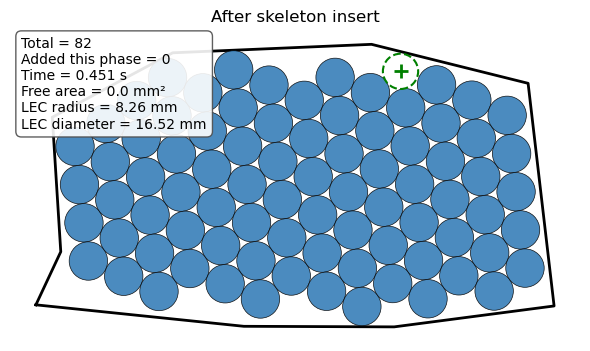

Area that could still host a centre: 2579.4 mm²
Largest empty circle radius: 2.25 mm (4.49 mm diameter)
Saved 82 circle centres to out.csv


In [2]:
poly, _, meta = cp.load_boundary(Path(json_file), to_units="mm", require_scale=False)
print(f"[loader] units=mm, px->mm={meta['px_to_mm']:.5f}, scale_cm_per_px={meta['scale_cm_per_px']}")

# 1 ─ aligned hex grid (finer phase scan gives 1-3 extra cells)
centres = cp.best_hex_seed_two_angles(poly, n_phase=16)
print("hex grid :", len(centres))

# pso refine (deleted for now, see below)
#centres1 = pso_refine(centres0, poly)
#print("PSO done")

# 2 ─ first greedy insertion (fills obvious edge gaps)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=6)
print("after greedy :", len(centres))

# 3 ─ local compaction (Python re-implementation of Zhou’s batch-BFGS)
centres = cp.batch_bfgs_compact(centres, R, poly, n_pass=4)
print("after compaction :", len(centres))

# 4 ─ second greedy pass (micron pockets now opened by compactor)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=3)
print("final count :", len(centres))

prev = len(centres)
t0 = cp.perf_counter()
centres = cp.skeleton_insert(poly, centres, step=2.0)
t1 = cp.perf_counter()
cp.plot_phase(poly, centres, added_idx=np.arange(prev, len(centres)),
        title="After skeleton insert", r=R, time_s=t1 - t0)

# ───▶  DIAGNOSTIC POCKET ANALYSIS  ◀─────────────────────────────────────
free     = poly.buffer(-R).buffer(0)            # safe interior strip
hull     = cp.unary_union([Point(x, y).buffer(R) for x, y in centres])
residual = free.difference(hull)

print(f"Area that could still host a centre: {residual.area:.1f} mm²")

# Optional: largest empty circle (Shapely≥2.0 only)
try:
    from shapely import maximum_inscribed_circle

    rad, centre_pt = cp.largest_empty_circle(residual)
    if rad > 0:
        print(f"Largest empty circle radius: {rad:.2f} mm "
            f"({2*rad:.2f} mm diameter)")
    else:
        print("Residual pocket too thin for even a tiny extra cell.")
except ImportError:
    pass
# ─────────────────────────────────────────────────────────────────────────

# 5 ─ save + preview
np.savetxt(out_csv, centres, delimiter=",", header="x,y", comments="")
print(f"Saved {centres.shape[0]} circle centres to {out_csv}")

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 7 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x419fa5ebfc4476c1)
#Variables: 27'521 (#bools: 34 #ints: 35 in objective) (24'431 primary variables)
  - 27'486 Booleans in [0,1]
  - 1 in [0,4]
  - 34 in [0,420]
#kLinear1: 34
#kLinear2: 46'233
#kLinear3: 315
#kLinearN: 2'823 (#terms: 48'171)

Starting presolve at 0.02s
  1.07e-02s  0.00e+00d  [DetectDominanceRelations] 
  8.23e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  6.31e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=3'034 #potential_subsets=34 
  6.82e-04s  0.00e+00d  [DetectDuplicateColumns] 
  1.13e-03s  0.00e+00d  [DetectDuplicateConstraints] #duplicates=82 
[Symmetry] Gra

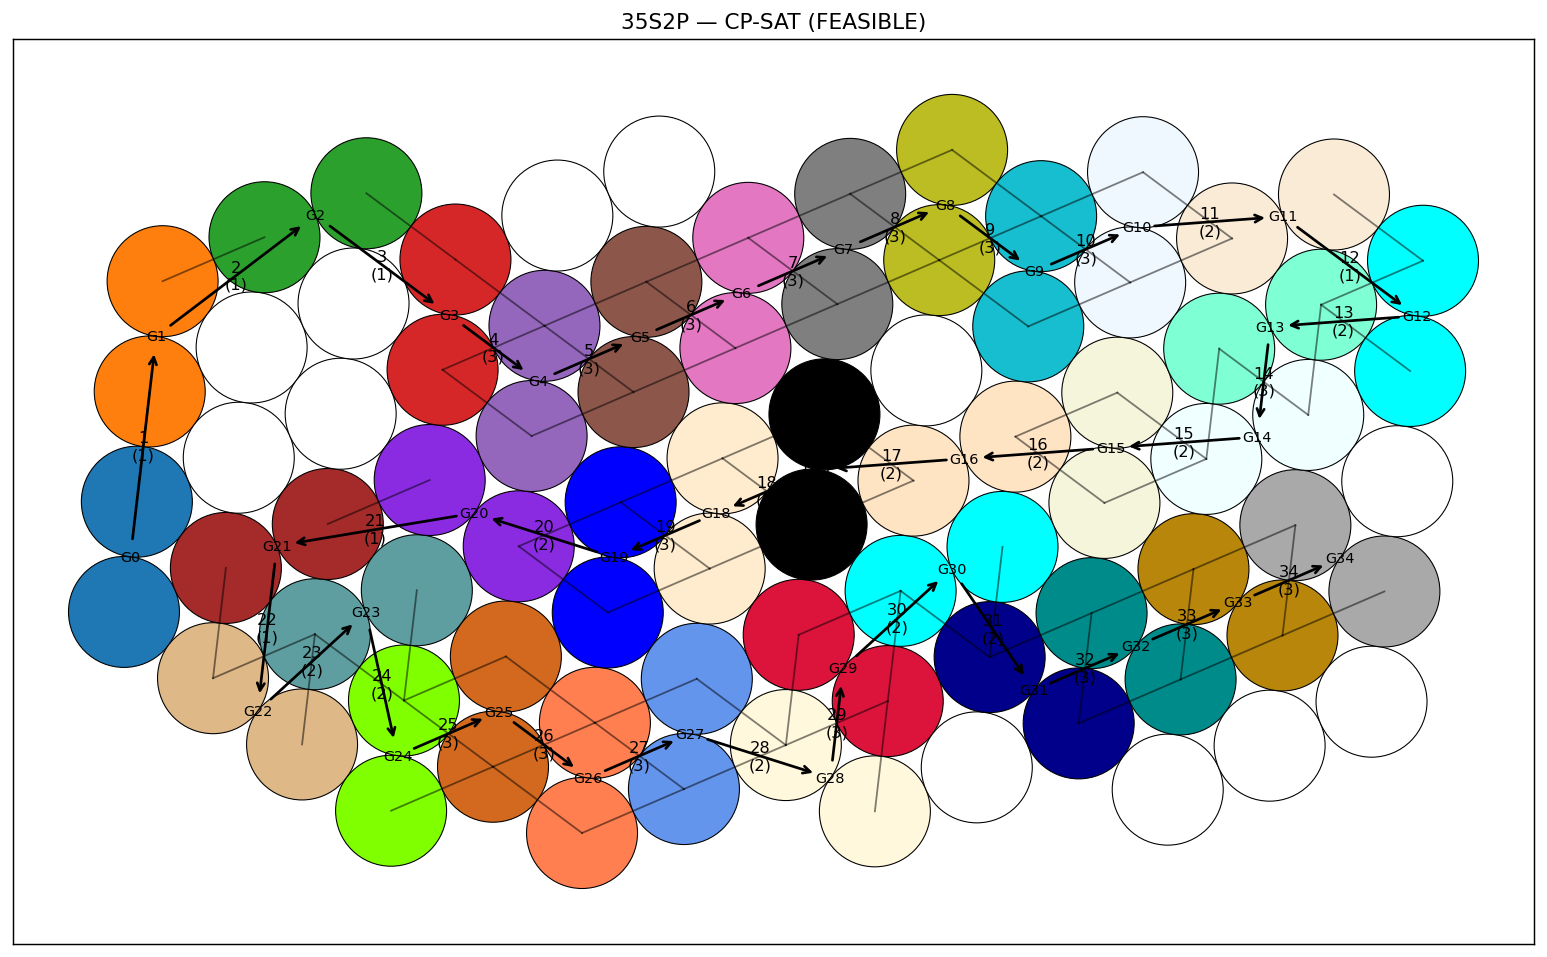

In [ ]:
import battery_layout_cpsat_v2 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 35
P = 2
radius = 9.0
tol = 2
time_budget = 30
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=False

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 7 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x80bee4f9cffe9b07)
#Variables: 18'393 (#bools: 22 #ints: 24 in objective) (16'121 primary variables)
  - 18'369 Booleans in [0,1]
  - 1 in [0,6]
  - 1 in [0,82]
  - 22 in [0,420]
#kLinear1: 22
#kLinear2: 30'727
#kLinear3: 216
#kLinearN: 1'985 (#terms: 32'308)

Starting presolve at 0.01s
  8.21e-03s  0.00e+00d  [DetectDominanceRelations] 
  5.76e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  8.11e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=2'131 #potential_subsets=22 
  4.13e-04s  0.00e+00d  [DetectDuplicateColumns] 
  6.16e-04s  0.00e+00d  [DetectDuplicateConstraints] 
[Symmetry] Gr

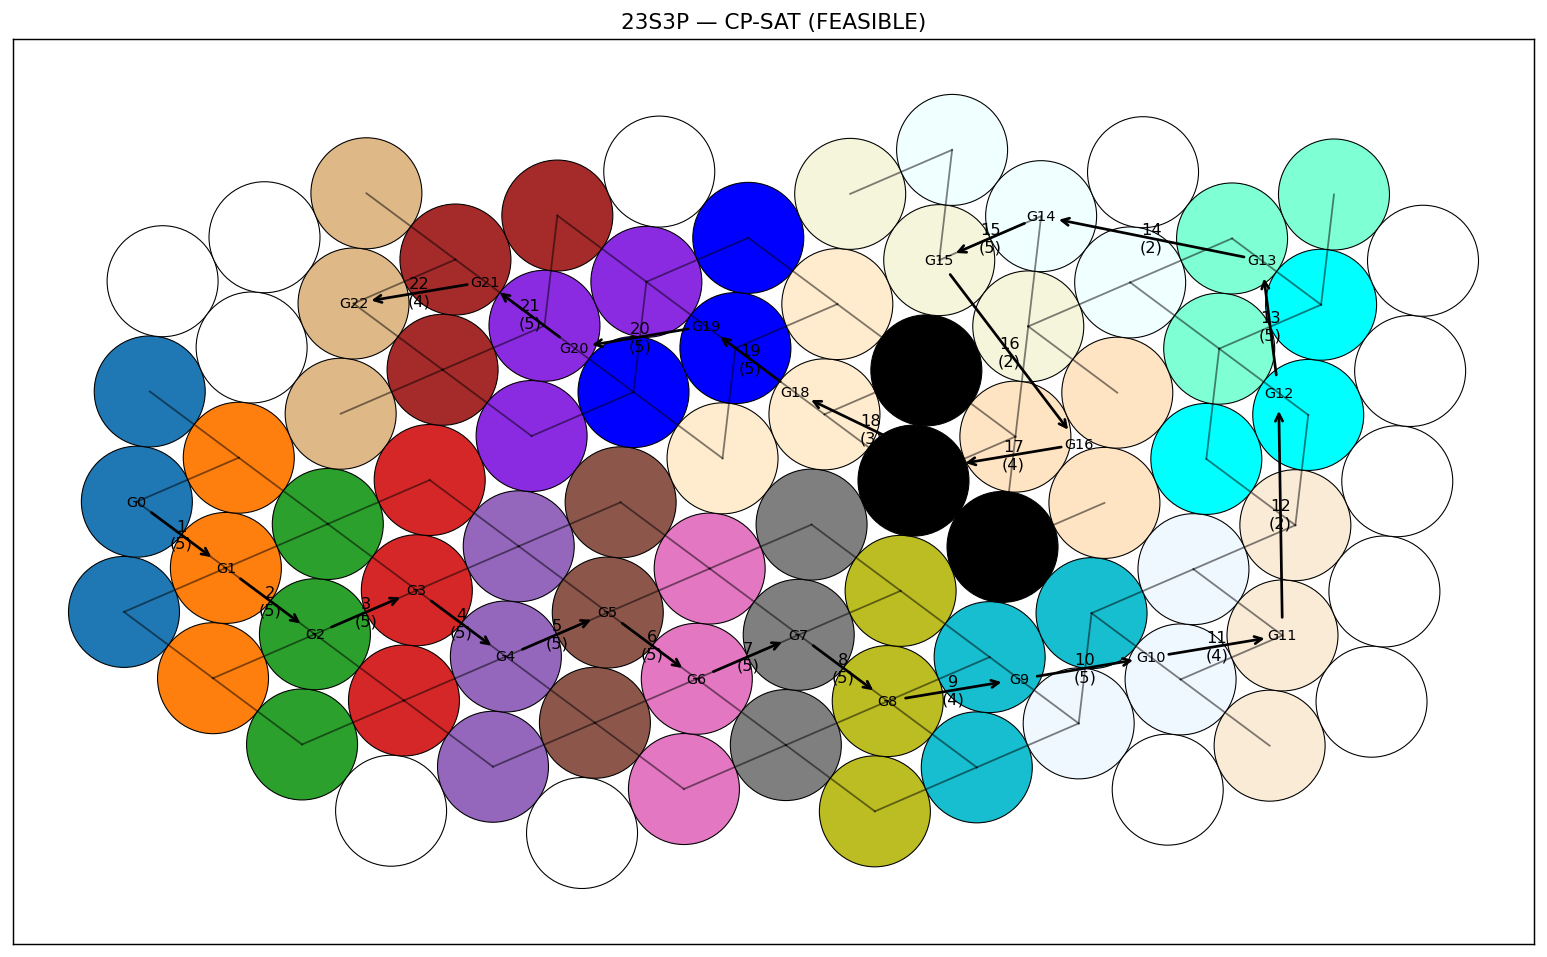

In [ ]:
import battery_layout_cpsat_v3 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 23
P = 3
radius = 9.0
tol = 2
time_budget = 30
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 30 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0xced0e5f5a61f9d88)
#Variables: 12'322 (#bools: 16 #ints: 16 in objective) (10'654 primary variables)
  - 12'306 Booleans in [0,1]
  - 1 in [0,10]
  - 1 in [0,82]
  - 14 in [0,420]
#kLinMax: 2 (#expressions: 164)
#kLinear1: 47
#kLinear2: 20'638
#kLinear3: 308
#kLinearN: 1'426 (#terms: 21'563)

Starting presolve at 0.01s
  4.49e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.80e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  2.03e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=1'475 #potential_subsets=14 
  2.71e-04s  0.00e+00d  [DetectDuplicateColumns] 
  4.15e-04s  0.00e+00d  [DetectDu

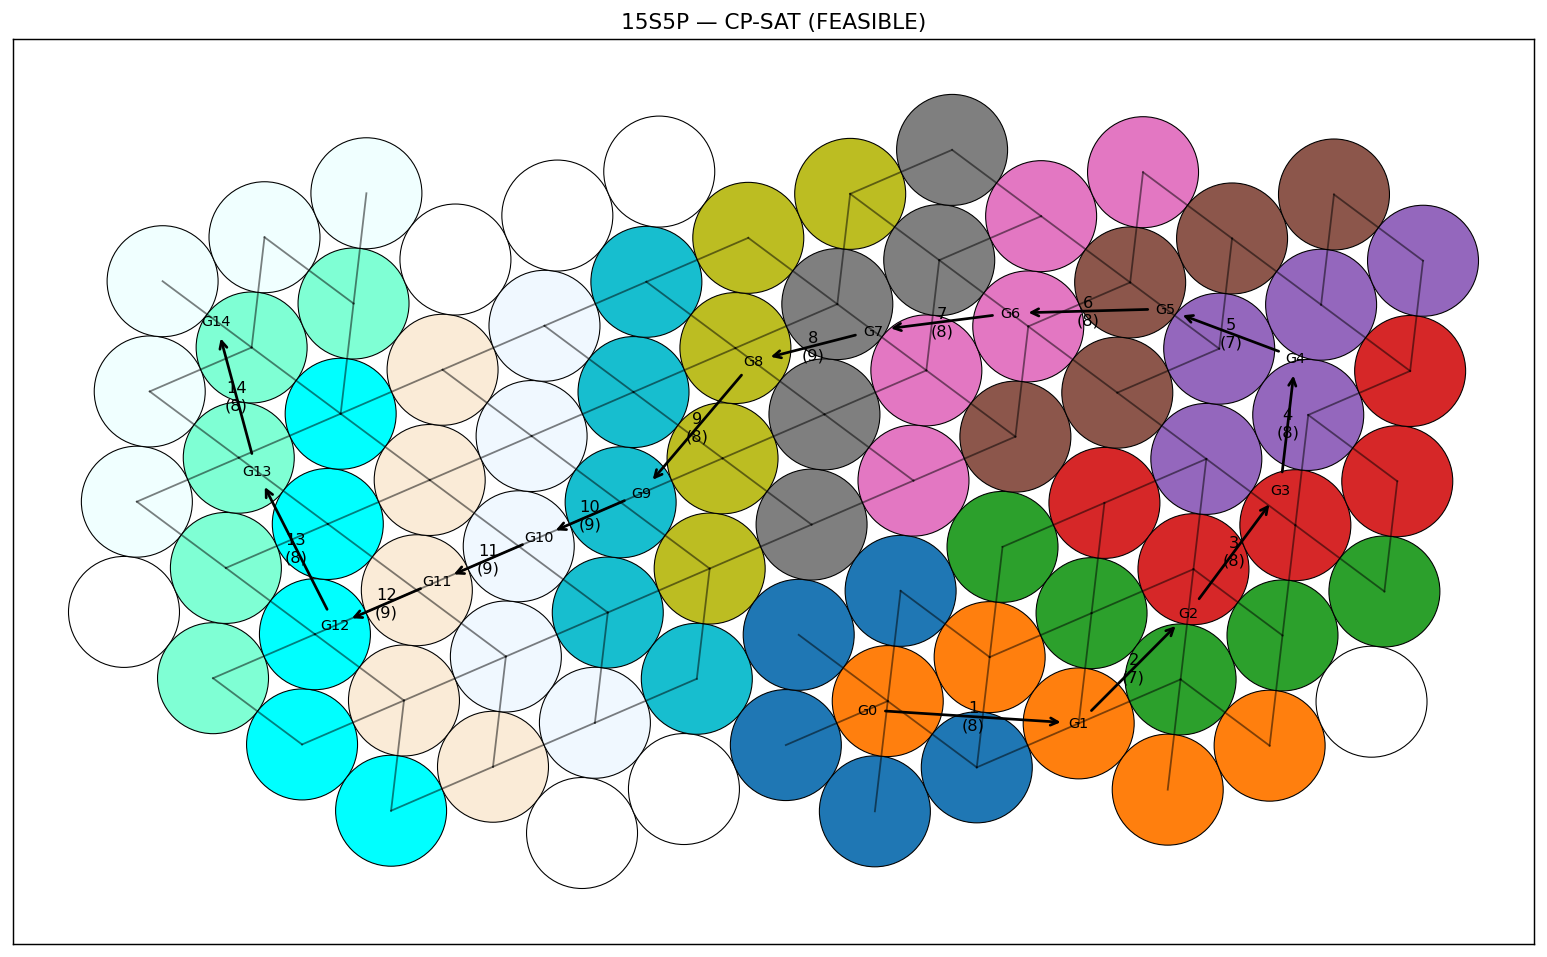

In [ ]:
import battery_layout_cpsat_v4 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 10
P = 8
radius = 9.0
tol = 2
time_budget = 120
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 5 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x9beddfd779f01f1f)
Search strategy: on 1230 variables, CHOOSE_FIRST, SELECT_MAX_VALUE
Search strategy: on 1230 variables, CHOOSE_FIRST, SELECT_MAX_VALUE
#Variables: 12'337 (#bools: 16 #ints: 16 in objective) (10'684 primary variables)
  - 12'306 Booleans in [0,1]
  - 1 in [0,10]
  - 14 in [0,60]
  - 1 in [0,82]
  - 15 in [18338,231066]
#kLinMax: 2 (#expressions: 164)
#kLinear1: 47
#kLinear2: 20'652
#kLinear3: 308
#kLinearN: 1'441 (#terms: 22'808)

Starting presolve at 0.01s
  5.87e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.09e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=16 #num_dual_strengthening=2 
  1.51e-03s  0.00e+00d  [Ex

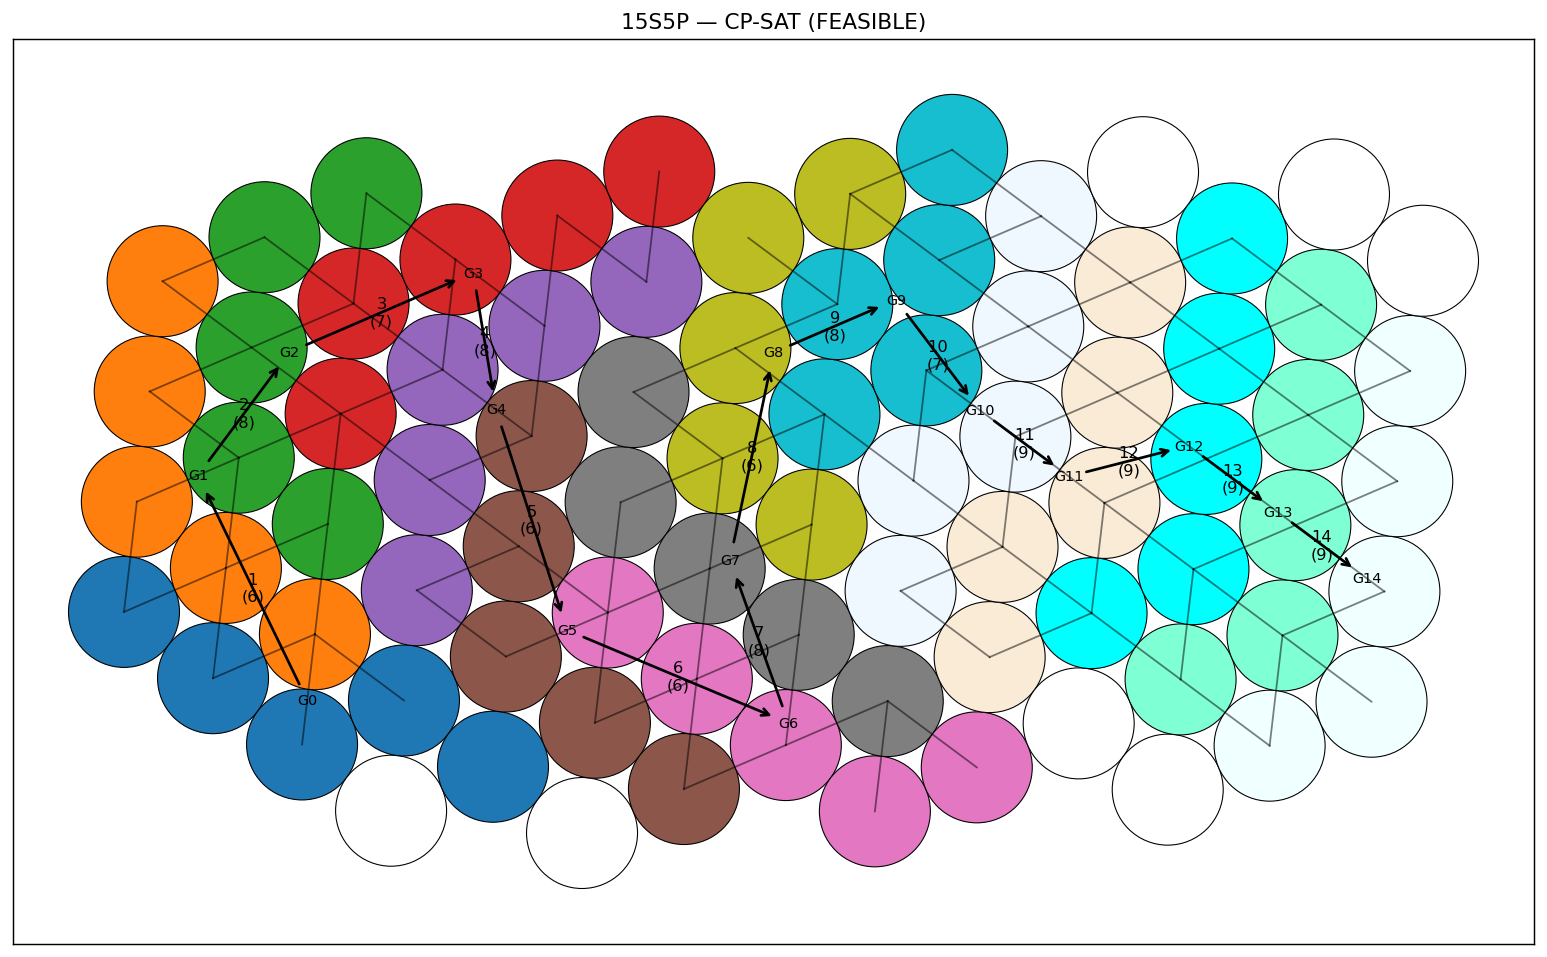

In [ ]:
import battery_layout_cpsat_v5 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 10
P = 8
radius = 9.0
tol = 2
time_budget = 10
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")